<a href="https://colab.research.google.com/github/dimidagd/gists/blob/main/explainable_attention_in_BERT_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q transformers
! pip install -q captum
from captum.attr import visualization

In [248]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import AutoModelForSequenceClassification
sentiment_model = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
base_model = 'xlm-roberta-base'
model_name = sentiment_model
tokenizer = AutoTokenizer.from_pretrained(model_name)

model_class = AutoModelForMaskedLM if model_name==base_model else AutoModelForSequenceClassification
model = model_class.from_pretrained(model_name,output_attentions=True)
model.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [249]:
state = {}
def hook(module, inputs, outputs):
  state["outputs"] = outputs
hook = model.roberta.encoder.register_forward_hook(hook)


In [434]:
# prepare input
text = "I don't like the taste of this food. It feels too greasy and lacks seasoning. I can't imagine eating this again."
encoded_input = tokenizer(text, return_tensors='pt')
input_ids = encoded_input['input_ids']
attention_mask = encoded_input['attention_mask']
output = model(**encoded_input)

In [435]:
prediction_vector = output[0].squeeze(0).softmax(0) # Index first element in batch, then  then the CLS token logits
print(prediction_vector.sum()) # Predictions are softmaxed
print(prediction_vector)

tensor(1., grad_fn=<SumBackward0>)
tensor([0.9525, 0.0339, 0.0137], grad_fn=<SoftmaxBackward0>)


In [436]:
print(type(state["outputs"])) # Check the output type from the encoder

<class 'transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions'>


In [437]:
# Figure out the output schema from source code
# https://github.com/huggingface/transformers/blob/f5c0fa9f6fe0eea2ad69bb1b03aff04824aa4870/src/transformers/modeling_outputs.py#L245
!wget -q -O - "https://raw.githubusercontent.com/huggingface/transformers/f5c0fa9f6fe0eea2ad69bb1b03aff04824aa4870/src/transformers/modeling_outputs.py" | cat | grep -A 30 "class BaseModelOutputWithPastAndCrossAttentions"

class BaseModelOutputWithPastAndCrossAttentions(ModelOutput):
    """
    Base class for model's outputs that may also contain a past key/values (to speed up sequential decoding).

    Args:
        last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
            Sequence of hidden-states at the output of the last layer of the model.

            If `past_key_values` is used only the last hidden-state of the sequences of shape `(batch_size, 1,
            hidden_size)` is output.
        past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
            Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of shape
            `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and optionally if
            `config.is_encoder_decoder=True` 2 additional tensors of shape `(batch_size, num_heads,
            

In [438]:
len(state["outputs"].attentions)
cls_token_attention_vector = state["outputs"].attentions[0].squeeze(0)
print("N_HEAD x N_TOKEN x N_TOKEN ->", cls_token_attention_vector.shape)
print(cls_token_attention_vector[0,0].sum()) # Attention is softmaxed so a tokens attention weights to the rest should sum to 0
from torch.nn.functional import softmax

N_HEAD x N_TOKEN x N_TOKEN -> torch.Size([12, 35, 35])
tensor(1.0000, grad_fn=<SumBackward0>)


In [439]:
print(model.roberta.encoder.config.num_attention_heads)
print(state["outputs"].attentions[0].shape)

12
torch.Size([1, 12, 35, 35])


In [440]:
import torch
torch.rand(3,9).min(0).values.shape

torch.Size([9])

In [441]:
reduce_dim_pca(tensor).shape

torch.Size([1, 14, 14])

In [442]:
from sklearn.decomposition import PCA

def reduce_dim_pca(tensor, n_components=1):
    """
    Reduces the dimensions of a tensor from MxNxK to 1xNxK using PCA.

    Args:
    tensor (torch.Tensor): Input tensor of shape (M, N, K).
    n_components (int): Number of components to keep (default is 1).

    Returns:
    torch.Tensor: Reduced tensor of shape (1, N, K).
    """
    M, N, K = tensor.shape

    # Reshape the tensor to (M, N*K)
    tensor_reshaped = tensor.reshape(M, -1).detach().numpy()

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(tensor_reshaped.T)  # shape: (N*K, n_components)

    # Reshape the PCA result to (n_components, N, K)
    pca_result_reshaped = torch.tensor(pca_result.T).view(n_components, N, K)

    return pca_result_reshaped

In [443]:

import torch

def minmax_scale(data, dim):
    """
    Min-max scale a tensor along a specified dimension.

    Args:
    data (torch.Tensor): Input tensor.
    dim (int): Dimension along which to perform min-max scaling.

    Returns:
    torch.Tensor: Min-max scaled tensor.
    """
    min_vals, _ = torch.min(data, dim=dim, keepdim=True)
    max_vals, _ = torch.max(data, dim=dim, keepdim=True)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data


torch.Size([25, 25])
tensor([0.9467, 0.2805, 0.6274, 0.6310, 0.3552, 0.1292, 0.2600, 0.9643, 0.2541,
        0.2820, 0.8588, 0.7201, 0.6659, 0.0000, 0.5785, 0.5626, 0.8029, 1.0000,
        0.5174, 0.7220, 0.9311, 0.0090, 0.9463, 0.8985, 0.1668])


In [452]:
cls_token_attention_vector[:,token_idx,1:-1,].shape

torch.Size([12, 33])

tensor([ 1.1297,  0.8505,  0.8214, -0.1845,  0.2590, -1.5605,  1.8270, -0.1865,
        -1.4315,  0.3162,  0.3685, -0.4960,  0.6238,  0.0361, -0.1890,  1.5914,
         0.5943,  1.4209, -1.3694,  0.2349,  0.1769,  0.6928,  0.4309,  0.2282,
         0.7280, -0.8307,  0.7607, -0.4552, -0.3209, -1.3729, -1.5578, -0.5706,
        -0.5283])
Predicted class is 0 with confidence 0.9524588584899902
('▁I', 0.7941616177558899)
('▁don', 0.711746096611023)
("'", 0.7031429409980774)
('t', 0.4062028229236603)
('▁like', 0.5371155738830566)
('▁the', 0.0)
('▁taste', 1.0)
('▁of', 0.4056118428707123)
('▁this', 0.03809262067079544)
('▁food', 0.5540044903755188)
('.', 0.5694460272789001)
('▁It', 0.3142610788345337)
('▁feel', 0.6448051333427429)
('s', 0.4713291823863983)
('▁too', 0.4048614203929901)
('▁gre', 0.9304449558258057)
('as', 0.6360969543457031)
('y', 0.8801218271255493)
('▁and', 0.05643359571695328)
('▁la', 0.5300204157829285)
('cks', 0.5128896236419678)
('▁season', 0.6651731729507446)
('ing', 0.5

Text(0.5, 1.0, 'Attention Head vs. Weight Index')

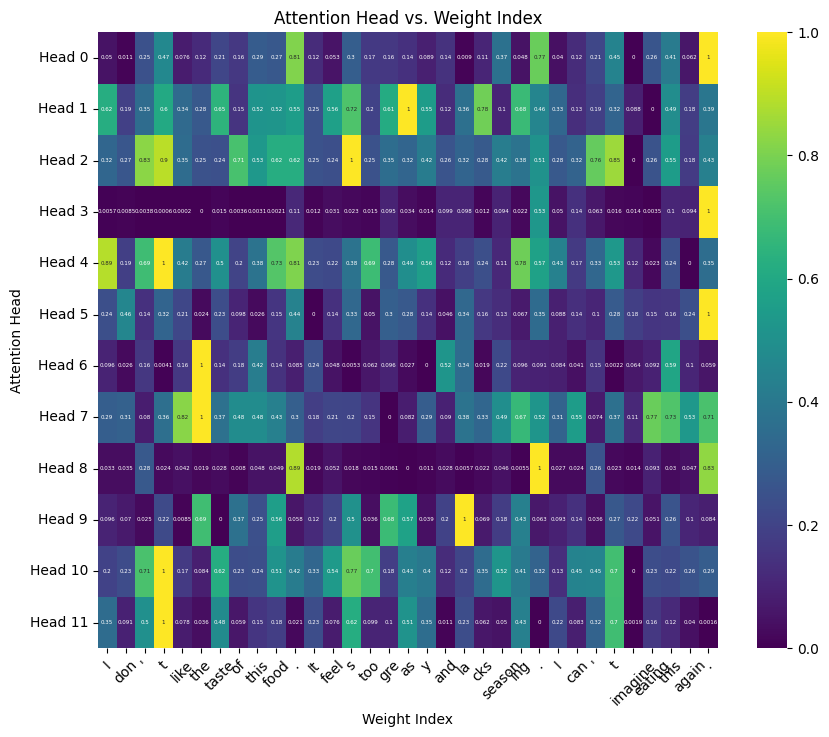

In [460]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.flatten())
head_idx = 0
token_idx = 0
#expl = cls_token_attention_vector[:][token_idx].mean(0)
expl = reduce_dim_pca(minmax_scale(cls_token_attention_vector,dim=0)[:][token_idx].unsqueeze(1)).squeeze(0).squeeze(0)
#expl = reduce_dim_pca(cls_token_attention_vector).squeeze(0)[token_idx]
tokens = tokens[1:-1]
expl = expl[1:-1] # Remove start and end tokens
print(expl)
expl = minmax_scale(expl.unsqueeze(0),dim=1)[0]
true_class = 0

predicted_class = prediction_vector.argmax(dim=-1).item()
predicted_prob = prediction_vector[predicted_class].item() # XXX: Use model output here
print(f"Predicted class is {predicted_class} with confidence {predicted_prob}")
for i in range(len(tokens)):
  print((tokens[i], expl[i].item()))
if true_class == 0:
  expl *= (-1)
vis_data_records = [visualization.VisualizationDataRecord(
                                expl,
                                predicted_prob,
                                predicted_class,
                                true_class,
                                true_class,
                                1,
                                tokens,
                                1)]
visualization.visualize_text(vis_data_records)

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Sample data: M attention heads and N weights
tokens = tokenizer.convert_ids_to_tokens(input_ids.flatten())
tokens = [token.replace('▁', '') for token in tokens]
data = cls_token_attention_vector[:,token_idx,1:-1]
minmaxed_attention_matrix = minmax_scale(data,dim=1)
data = minmaxed_attention_matrix.detach().numpy()


tokens = tokens[1:-1]
M = data.shape[0]  # number of attention heads
N = data.shape[1]  # number of weights
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data, annot=True, cmap='viridis', yticklabels=[f'Head {i}' for i in range(M)], xticklabels=tokens,annot_kws={"size": 4})

# Adding labels
plt.xlabel('Weight Index')
plt.xticks(rotation=45)
plt.ylabel('Attention Head')
plt.title('Attention Head vs. Weight Index')
